**Chapter 18 – Autoencoders, GANs, and Diffusion Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 18._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

If using Colab or Kaggle, a few libraries are not pre-installed so we must install them manually:

In [2]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q torchmetrics

We also need PyTorch ≥ 2.4.0:

In [3]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.4.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [5]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

We will also be using the same `train()` and `evaluate_tm()` functions as in previous chapters, but with a couple tweaks to the `train()` function:
* Gradient clipping using `torch.nn.utils.clip_grad_norm_()`
* Support for named tuples outputs containing an `output` field (see the lines: `y_pred = y_pred.output if...`)

In [7]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=2, factor=0.5, epoch_callback=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        if epoch_callback is not None:
            epoch_callback(model, epoch)
        for index, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
            print(f"\rBatch {index + 1}/{len(train_loader)}", end="")
            print(f", loss={total_loss/(index+1):.4f}", end="")
            print(f", {train_metric=:.3f}", end="")
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"\rEpoch {epoch + 1}/{n_epochs},                      "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.3}, "
              f"valid metric: {history['valid_metrics'][-1]:.3}")
    return history

# Performing PCA with an Undercomplete Linear Autoencoder

Let's build the Autoencoder...

In [8]:
import torch
import torch.nn as nn

torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

Now let's generate the same 3D dataset as we used in Chapter 7:

In [9]:
# extra code – builds the same 3D dataset as in Chapter 7

import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed=42):
    X = np.zeros((m, 3))  # initialize 3D dataset
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
    X += 0.28 * rng.standard_normal((m, 3))  # add more noise
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]  # shift a bit
    return torch.from_numpy(X.astype(np.float32))

In [10]:
from torch.utils.data import DataLoader, TensorDataset

X_train = generate_data(60, seed=42)
train_set = TensorDataset(X_train, X_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [11]:
X_valid = generate_data(500, seed=43)
valid_set = TensorDataset(X_valid, X_valid)
valid_loader = DataLoader(valid_set, batch_size=32)

In [12]:
import torchmetrics

torch.manual_seed(42)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr=0.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(autoencoder, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=20)

Epoch 1/20,                      train loss: 0.1621, train metric: 0.406, valid metric: 0.309
Epoch 2/20,                      train loss: 0.0697, train metric: 0.264, valid metric: 0.297
Epoch 3/20,                      train loss: 0.0644, train metric: 0.253, valid metric: 0.324
Epoch 4/20,                      train loss: 0.0935, train metric: 0.303, valid metric: 0.45
Epoch 5/20,                      train loss: 0.1088, train metric: 0.336, valid metric: 0.245
Epoch 6/20,                      train loss: 0.0415, train metric: 0.203, valid metric: 0.235
Epoch 7/20,                      train loss: 0.0426, train metric: 0.205, valid metric: 0.273
Epoch 8/20,                      train loss: 0.0470, train metric: 0.218, valid metric: 0.211
Epoch 9/20,                      train loss: 0.0314, train metric: 0.179, valid metric: 0.213
Epoch 10/20,                      train loss: 0.0300, train metric: 0.174, valid metric: 0.209
Epoch 11/20,                      train loss: 0.0300, train 

In [13]:
codings = encoder(X_train.to(device))

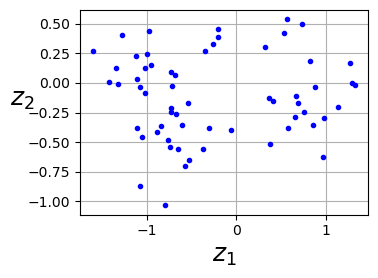

In [14]:
fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using PyTorch

Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [15]:
torch.manual_seed(42)  # extra code – ensures reproducibility

stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 32), nn.ReLU(),
)
stacked_decoder = nn.Sequential(
    nn.Linear(32, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
stacked_ae = nn.Sequential(stacked_encoder, stacked_decoder).to(device)

Let's load the fashion MNIST dataset, and split it into a training set, a validation set, and a test set:

In [16]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [17]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        return x, x

train_loader = DataLoader(AutoencoderDataset(train_data), batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(AutoencoderDataset(valid_data), batch_size=32)
test_loader = DataLoader(AutoencoderDataset(test_data), batch_size=32)

In [18]:
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr=0.01)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(stacked_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0249, train metric: 0.158, valid metric: 0.143
Epoch 2/10,                      train loss: 0.0195, train metric: 0.14, valid metric: 0.14
Epoch 3/10,                      train loss: 0.0186, train metric: 0.136, valid metric: 0.137
Epoch 4/10,                      train loss: 0.0182, train metric: 0.135, valid metric: 0.133
Epoch 5/10,                      train loss: 0.0160, train metric: 0.126, valid metric: 0.129
Epoch 6/10,                      train loss: 0.0157, train metric: 0.125, valid metric: 0.127
Epoch 7/10,                      train loss: 0.0155, train metric: 0.125, valid metric: 0.126
Epoch 8/10,                      train loss: 0.0147, train metric: 0.121, valid metric: 0.123
Epoch 9/10,                      train loss: 0.0145, train metric: 0.121, valid metric: 0.123
Epoch 10/10,                      train loss: 0.0144, train metric: 0.12, valid metric: 0.121


## Visualizing the Reconstructions

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

In [19]:
X_valid = torch.cat([x for x, _ in valid_data]).unsqueeze(dim=1)
y_valid = torch.tensor([y for _, y in valid_data])

In [20]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_reconstructions(model, images=X_valid, n_images=5):
    images = images[:n_images]
    with torch.no_grad():
        y_pred = model(images.to(device))
    if isinstance(y_pred, tuple):
        y_pred = y_pred.output
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), 1 + idx)
        plot_image(images[idx])
        plt.subplot(2, len(images), 1 + len(images) + idx)
        plot_image(y_pred[idx])

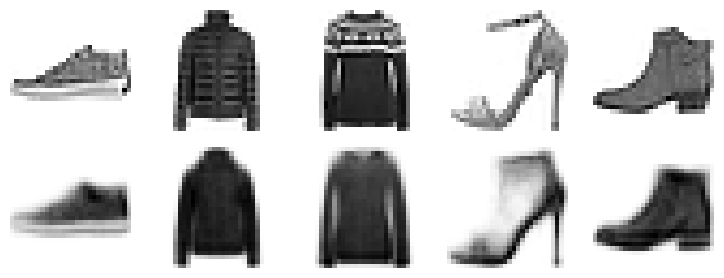

In [21]:
plot_reconstructions(stacked_ae)

plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 32 numbers, instead of 784.

## Using AutoEncoders for Anomaly Detection

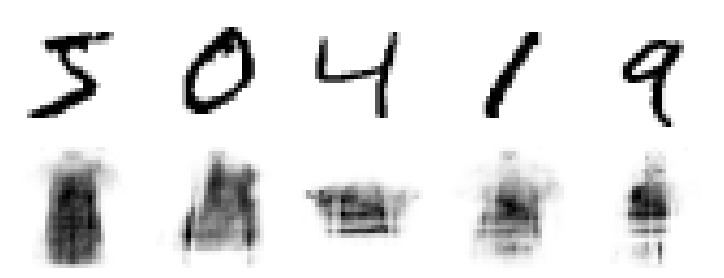

In [22]:
torch.manual_seed(42)
mnist_data = torchvision.datasets.MNIST(
    root="datasets", train=True, download=True, transform=toTensor)
mnist_images = torch.stack([mnist_data[i][0] for i in range(5)])
plot_reconstructions(stacked_ae, images=mnist_images)

plt.show()

In [23]:
images = mnist_images.to(device)
with torch.no_grad():
    y_pred = stacked_ae(images)
recon_loss = F.mse_loss(y_pred, images)

tensor(0.0644, device='mps:0')

## Visualizing the Fashion MNIST Dataset

In [24]:
from sklearn.manifold import TSNE

with torch.no_grad():
    X_valid_compressed = stacked_encoder(X_valid.to(device))

tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed.cpu())

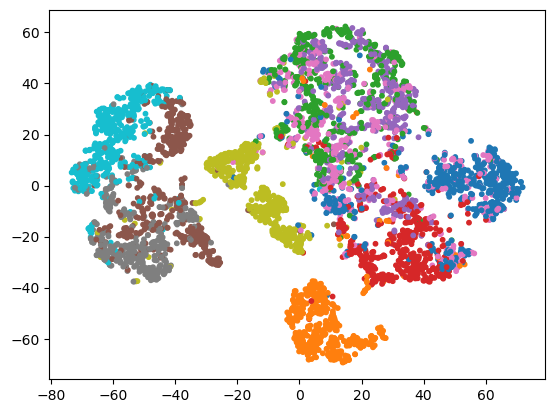

In [25]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

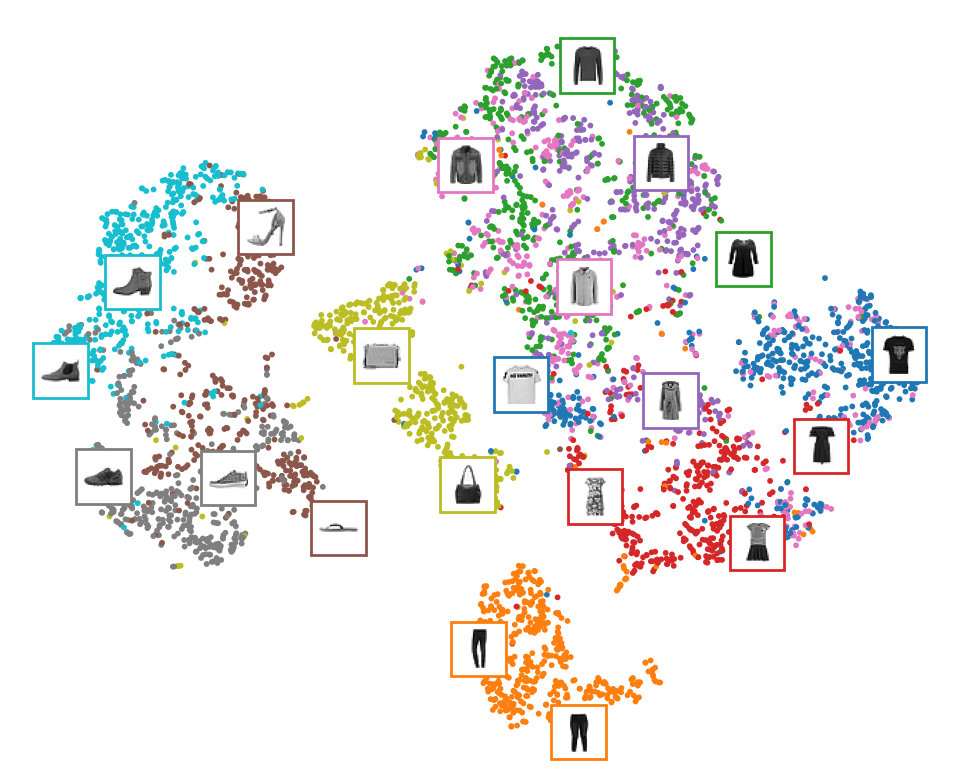

In [26]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index].squeeze(dim=0),
                                      cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we can use a custom module.

In [27]:
import torch.nn.functional as F

class TiedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Linear(1 * 28 * 28, 128)
        self.enc2 = nn.Linear(128, 32)
        self.dec1_bias = nn.Parameter(torch.zeros(128))
        self.dec2_bias = nn.Parameter(torch.zeros(1 * 28 * 28))

    def encode(self, X):
        Z = X.view(-1, 1 * 28 * 28)  # flatten
        Z = F.relu(self.enc1(Z))
        return F.relu(self.enc2(Z))
        
    def decode(self, X):
        Z = F.relu(F.linear(X, self.enc2.weight.t(), self.dec1_bias))
        Z = F.sigmoid(F.linear(Z, self.enc1.weight.t(), self.dec2_bias))
        return Z.view(-1, 1, 28, 28)  # unflatten

    def forward(self, X):
        return self.decode(self.encode(X))

In [28]:
tied_ae = TiedAutoencoder().to(device)
optimizer = torch.optim.NAdam(tied_ae.parameters(), lr=0.01)
history = train(tied_ae, optimizer, mse, rmse, train_loader, valid_loader, n_epochs=10)

Epoch 1/10,                      train loss: 0.0223, train metric: 0.149, valid metric: 0.138
Epoch 2/10,                      train loss: 0.0170, train metric: 0.131, valid metric: 0.134
Epoch 3/10,                      train loss: 0.0163, train metric: 0.128, valid metric: 0.128
Epoch 4/10,                      train loss: 0.0160, train metric: 0.126, valid metric: 0.127
Epoch 5/10,                      train loss: 0.0139, train metric: 0.118, valid metric: 0.118
Epoch 6/10,                      train loss: 0.0135, train metric: 0.116, valid metric: 0.117
Epoch 7/10,                      train loss: 0.0133, train metric: 0.115, valid metric: 0.116
Epoch 8/10,                      train loss: 0.0124, train metric: 0.111, valid metric: 0.112
Epoch 9/10,                      train loss: 0.0122, train metric: 0.11, valid metric: 0.111
Epoch 10/10,                      train loss: 0.0121, train metric: 0.11, valid metric: 0.111


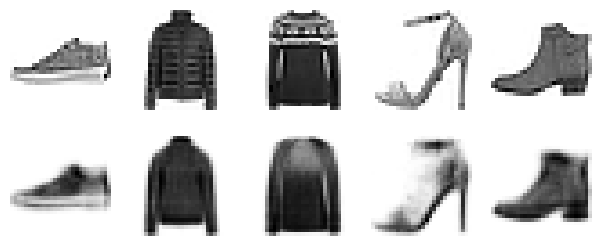

In [29]:
# extra code – plots reconstructions
plot_reconstructions(tied_ae)
plt.show()

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [30]:
torch.manual_seed(42)  # extra code – ensures reproducibility

conv_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 16 × 14 × 14
    nn.Conv2d(16, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 32 × 7 × 7
    nn.Conv2d(32, 64, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 64 × 3 × 3
    nn.Conv2d(64, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())  # output: 32

conv_decoder = nn.Sequential(
    nn.Linear(32, 16 * 3 * 3),
    nn.Unflatten(dim=1, unflattened_size=(16, 3, 3)),
    nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.Sigmoid())

conv_ae = nn.Sequential(conv_encoder, conv_decoder).to(device)

In [31]:
optimizer = torch.optim.NAdam(conv_ae.parameters(), lr=0.005)
history = train(conv_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0285, train metric: 0.169, valid metric: 0.135
Epoch 2/10,                      train loss: 0.0169, train metric: 0.13, valid metric: 0.124
Epoch 3/10,                      train loss: 0.0146, train metric: 0.121, valid metric: 0.12
Epoch 4/10,                      train loss: 0.0135, train metric: 0.116, valid metric: 0.113
Epoch 5/10,                      train loss: 0.0121, train metric: 0.11, valid metric: 0.11
Epoch 6/10,                      train loss: 0.0119, train metric: 0.109, valid metric: 0.109
Epoch 7/10,                      train loss: 0.0116, train metric: 0.108, valid metric: 0.107
Epoch 8/10,                      train loss: 0.0112, train metric: 0.106, valid metric: 0.106
Epoch 9/10,                      train loss: 0.0111, train metric: 0.105, valid metric: 0.106
Epoch 10/10,                      train loss: 0.0110, train metric: 0.105, valid metric: 0.105


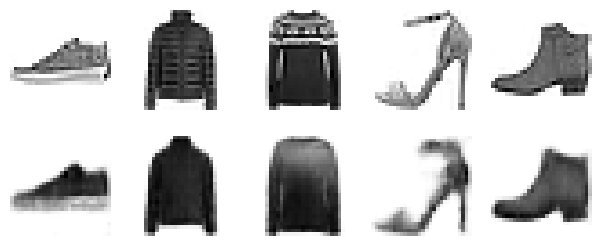

In [32]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

# Extra Material – Recurrent Autoencoders

Let's treat each Fashion MNIST image as a sequence of 28 vectors, each with 28 dimensions:

In [33]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_size=28, hidden_size=128,
                                    num_layers=2, batch_first=True)
        self.encoder_proj = nn.Linear(128, 32)  # Compress to latent vector
        self.decoder_lstm = nn.LSTM(input_size=32, hidden_size=128,
                                    batch_first=True)
        self.decoder_proj = nn.Linear(128, 28)

    def encode(self, X):  # X shape: [B, 1, 28, 28]
        Z = X.squeeze(dim=1)  # Z shape: [B, 28, 28]
        _, (h_n, _) = self.encoder_lstm(Z)  # h_n shape: [2, B, 100]
        Z = h_n[-1]  # get the hidden state of the last layer: [B, 100]
        return self.encoder_proj(Z)  # [B, 30]

    def decode(self, X):
        Z = X.unsqueeze(dim=1).repeat(1, 28, 1)  # [B, 28, 32]
        Z, _ = self.decoder_lstm(Z)  # [B, 28, 100]
        return F.sigmoid(self.decoder_proj(Z).unsqueeze(dim=1)) # [B, 1, 28, 28]
    
    def forward(self, X):
        return self.decode(self.encode(X))

torch.manual_seed(42)
recurrent_ae = RecurrentAutoencoder().to(device)

In [34]:
optimizer = torch.optim.NAdam(recurrent_ae.parameters(), lr=1e-3)
history = train(recurrent_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0570, train metric: 0.239, valid metric: 0.185
Epoch 2/10,                      train loss: 0.0264, train metric: 0.162, valid metric: 0.153
Epoch 3/10,                      train loss: 0.0211, train metric: 0.145, valid metric: 0.139
Epoch 4/10,                      train loss: 0.0178, train metric: 0.133, valid metric: 0.129
Epoch 5/10,                      train loss: 0.0152, train metric: 0.123, valid metric: 0.122
Epoch 6/10,                      train loss: 0.0141, train metric: 0.119, valid metric: 0.12
Epoch 7/10,                      train loss: 0.0132, train metric: 0.115, valid metric: 0.115
Epoch 8/10,                      train loss: 0.0124, train metric: 0.111, valid metric: 0.112
Epoch 9/10,                      train loss: 0.0120, train metric: 0.11, valid metric: 0.11
Epoch 10/10,                      train loss: 0.0117, train metric: 0.108, valid metric: 0.109


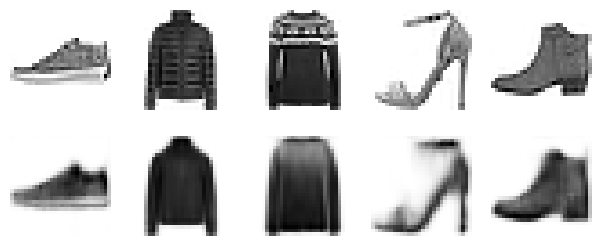

In [35]:
plot_reconstructions(recurrent_ae)
plt.show()

# Denoising Autoencoders

Using dropout:

In [36]:
torch.manual_seed(42)  # extra code – ensures reproducibility

dropout_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
dropout_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
dropout_ae = nn.Sequential(dropout_encoder, dropout_decoder).to(device)

In [37]:
optimizer = torch.optim.NAdam(dropout_ae.parameters(), lr=0.01)
history = train(dropout_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0280, train metric: 0.167, valid metric: 0.148
Epoch 2/10,                      train loss: 0.0228, train metric: 0.151, valid metric: 0.145
Epoch 3/10,                      train loss: 0.0223, train metric: 0.149, valid metric: 0.143
Epoch 4/10,                      train loss: 0.0221, train metric: 0.149, valid metric: 0.144
Epoch 5/10,                      train loss: 0.0201, train metric: 0.142, valid metric: 0.137
Epoch 6/10,                      train loss: 0.0198, train metric: 0.141, valid metric: 0.136
Epoch 7/10,                      train loss: 0.0196, train metric: 0.14, valid metric: 0.135
Epoch 8/10,                      train loss: 0.0187, train metric: 0.137, valid metric: 0.131
Epoch 9/10,                      train loss: 0.0185, train metric: 0.136, valid metric: 0.13
Epoch 10/10,                      train loss: 0.0183, train metric: 0.135, valid metric: 0.13


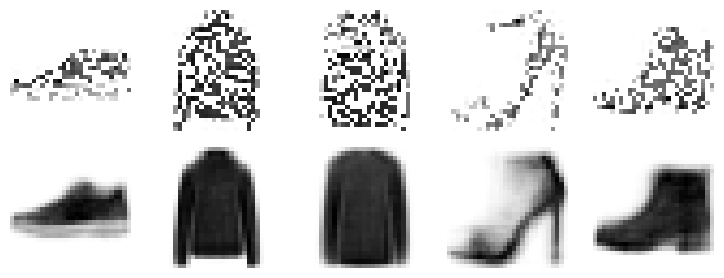

In [38]:
# extra code – this cell generates Figure 17–9
torch.manual_seed(42)
dropout = nn.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid))

plt.show()

Instead of using `Dropout`, we can add Gaussian noise:

In [39]:
class GaussianNoise(nn.Module):
    def __init__(self, std):
        super().__init__()
        self.std = std

    def forward(self, X):
        if self.training:  # only add noise during training
            noise = torch.randn_like(X) * self.std
            return X + noise
        return X

In [40]:
torch.manual_seed(42)  # extra code – ensures reproducibility

noise_encoder = nn.Sequential(
    nn.Flatten(),
    GaussianNoise(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
noise_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
noise_ae = nn.Sequential(noise_encoder, noise_decoder).to(device)

In [41]:
optimizer = torch.optim.NAdam(noise_ae.parameters(), lr=0.01)
history = train(noise_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0290, train metric: 0.17, valid metric: 0.148
Epoch 2/10,                      train loss: 0.0239, train metric: 0.155, valid metric: 0.146
Epoch 3/10,                      train loss: 0.0237, train metric: 0.154, valid metric: 0.145
Epoch 4/10,                      train loss: 0.0236, train metric: 0.154, valid metric: 0.148
Epoch 5/10,                      train loss: 0.0237, train metric: 0.154, valid metric: 0.148
Epoch 6/10,                      train loss: 0.0236, train metric: 0.154, valid metric: 0.147
Epoch 7/10,                      train loss: 0.0238, train metric: 0.154, valid metric: 0.148
Epoch 8/10,                      train loss: 0.0236, train metric: 0.154, valid metric: 0.148
Epoch 9/10,                      train loss: 0.0237, train metric: 0.154, valid metric: 0.149
Epoch 10/10,                      train loss: 0.0237, train metric: 0.154, valid metric: 0.146


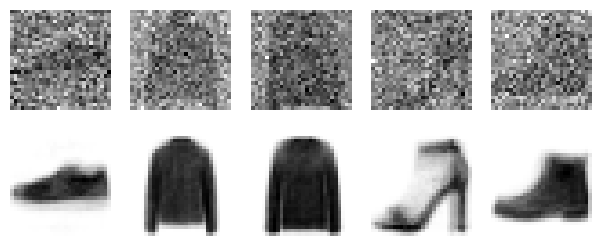

In [42]:
# extra code
torch.manual_seed(42)
noise = GaussianNoise(0.5)
plot_reconstructions(noise_ae, noise(X_valid))
plt.show()

# Sparse Autoencoder

Let's use the sigmoid activation function in the coding layer. Let's also add $\ell_1$ regularization to it: to do this, we make the module return both the reconstructions and the encodings (i.e., the output of the encoder), so the regularization loss can be computed based on the encodings.

In [43]:
from collections import namedtuple

AEOutput = namedtuple("AEOutput", ["output", "codings"])

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.Sigmoid())
        self.decoder = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        codings = self.encoder(X)
        output = self.decoder(codings)
        return AEOutput(output, codings)

In [44]:
def mse_plus_sparsity_loss(y_pred, y_target, target_sparsity=0.1,
                           kl_weight=1e-3, eps=1e-8):
    p = torch.tensor(target_sparsity, device=y_pred.codings.device)
    q = torch.clamp(y_pred.codings.mean(dim=0), eps, 1 - eps)  # actual sparsity
    kl_div = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
    return mse(y_pred.output, y_target) + kl_weight * kl_div.sum()

Let's plot the KL Divergence loss, versus the MAE and MSE:

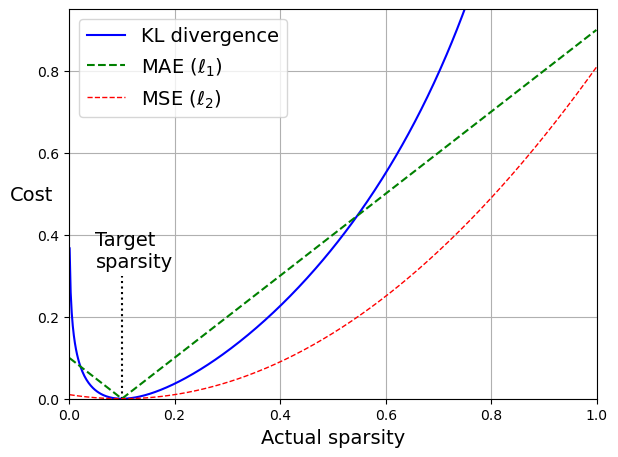

In [45]:
# extra code – this cell generates Figure 17–10
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse_ = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse_, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

In [46]:
torch.manual_seed(42)
sparse_ae = SparseAutoencoder().to(device)
optimizer = torch.optim.NAdam(sparse_ae.parameters(), lr=0.002)
history = train(sparse_ae, optimizer, mse_plus_sparsity_loss, rmse,
                train_loader, valid_loader, n_epochs=10)

Epoch 1/10,                      train loss: 0.0287, train metric: 0.165, valid metric: 0.133
Epoch 2/10,                      train loss: 0.0164, train metric: 0.125, valid metric: 0.121
Epoch 3/10,                      train loss: 0.0135, train metric: 0.114, valid metric: 0.11
Epoch 4/10,                      train loss: 0.0119, train metric: 0.107, valid metric: 0.106
Epoch 5/10,                      train loss: 0.0103, train metric: 0.0997, valid metric: 0.0991
Epoch 6/10,                      train loss: 0.0098, train metric: 0.0972, valid metric: 0.0971
Epoch 7/10,                      train loss: 0.0093, train metric: 0.095, valid metric: 0.0948
Epoch 8/10,                      train loss: 0.0088, train metric: 0.0924, valid metric: 0.0929
Epoch 9/10,                      train loss: 0.0086, train metric: 0.0914, valid metric: 0.0925
Epoch 10/10,                      train loss: 0.0084, train metric: 0.0905, valid metric: 0.0912


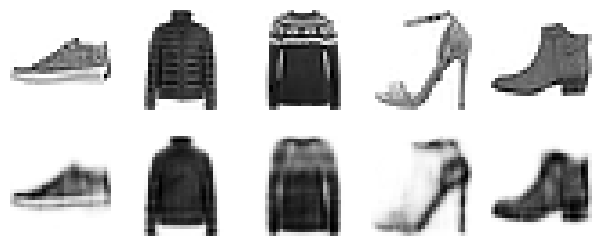

In [47]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_ae)
plt.show()

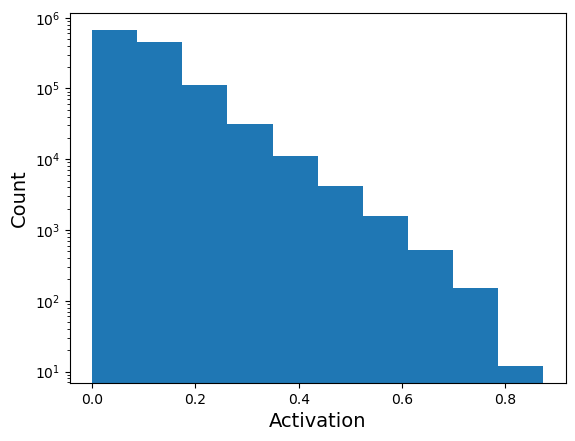

In [48]:
with torch.no_grad():
    y_pred = sparse_ae(X_valid.to(device))

encs = y_pred.codings.flatten().detach().cpu()
plt.hist(encs, log=True)
plt.xlabel("Activation")
plt.ylabel("Count")
plt.show()

In [49]:
y_pred.codings.mean()

tensor(0.1009, device='mps:0')

Sparse autoencoders often have fairly interpretable codings. For example, here are some images with a high coding #6: they are all shoes (however, it's not always the case when the model is a simple MLP, it's better when the model is a convolutional network).

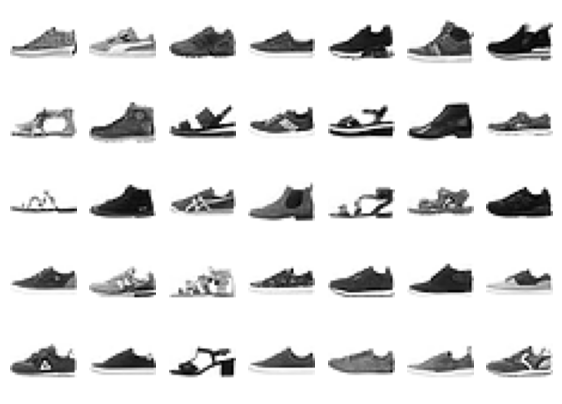

In [50]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)

dim = 6
codings = y_pred.codings[:, dim].cpu()
threshold = np.percentile(codings, 90)
selected_images = X_valid[codings > threshold]
plot_multiple_images(selected_images[:35], 7)
plt.show()

# Variational Autoencoder

In [51]:
VAEOutput = namedtuple("VAEOutput",
                       ["output", "codings_mean", "codings_logvar"])

class VAE(nn.Module):
    def __init__(self, codings_dim=32):
        super(VAE, self).__init__()
        self.codings_dim = codings_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 2 * codings_dim))  # output both the mean and logvar
        self.decoder = nn.Sequential(
            nn.Linear(codings_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def encode(self, X):
        return self.encoder(X).chunk(2, dim=-1)  # returns (mean, logvar)

    def sample_codings(self, codings_mean, codings_logvar):
        codings_std = torch.exp(0.5 * codings_logvar)
        noise = torch.randn_like(codings_std)
        return codings_mean + noise * codings_std

    def decode(self, Z):
        return self.decoder(Z)

    def forward(self, X):
        codings_mean, codings_logvar = self.encode(X)
        codings = self.sample_codings(codings_mean, codings_logvar)
        output = self.decode(codings)
        return VAEOutput(output, codings_mean, codings_logvar)

In [52]:
def vae_loss(y_pred, y_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.square(), dim=-1)
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [53]:
torch.manual_seed(42)
vae = VAE().to(device)
optimizer = torch.optim.NAdam(vae.parameters(), lr=1e-3)
history = train(vae, optimizer, vae_loss, rmse, train_loader, valid_loader,
                n_epochs=20)

Epoch 1/20,                      train loss: 0.0489, train metric: 0.204, valid metric: 0.177
Epoch 2/20,                      train loss: 0.0356, train metric: 0.166, valid metric: 0.163
Epoch 3/20,                      train loss: 0.0336, train metric: 0.159, valid metric: 0.158
Epoch 4/20,                      train loss: 0.0327, train metric: 0.155, valid metric: 0.155
Epoch 5/20,                      train loss: 0.0319, train metric: 0.152, valid metric: 0.153
Epoch 6/20,                      train loss: 0.0317, train metric: 0.151, valid metric: 0.151
Epoch 7/20,                      train loss: 0.0315, train metric: 0.15, valid metric: 0.151
Epoch 8/20,                      train loss: 0.0312, train metric: 0.149, valid metric: 0.15
Epoch 9/20,                      train loss: 0.0310, train metric: 0.149, valid metric: 0.15
Epoch 10/20,                      train loss: 0.0310, train metric: 0.148, valid metric: 0.149
Epoch 11/20,                      train loss: 0.0308, train me

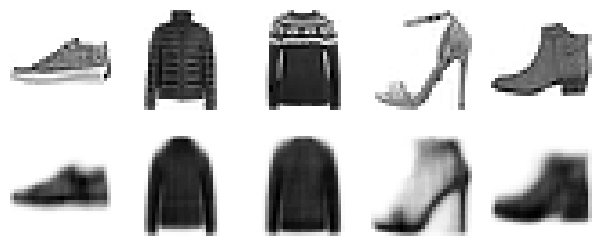

In [54]:
plot_reconstructions(vae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings and decode them:

In [55]:
torch.manual_seed(42)  # extra code – ensures reproducibility

vae.eval()
codings = torch.randn(3 * 7, vae.codings_dim, device=device)
with torch.no_grad():
    images = vae.decode(codings)

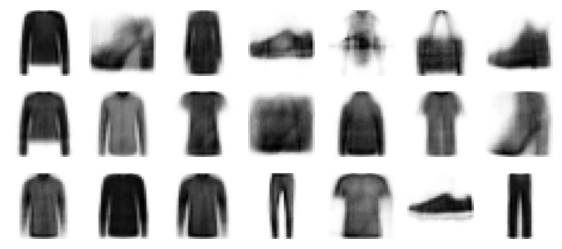

In [56]:
# extra code – this cells generates Figure 17-12

plot_multiple_images(images, 7)

plt.show()

Now let's perform semantic interpolation between 2 images:

In [57]:
codings.shape

torch.Size([21, 32])

In [58]:
torch.manual_seed(111)  # extra code – ensure reproducibility

codings = torch.randn(2, vae.codings_dim)  # start and end codings
n_images = 7
weights = torch.linspace(0, 1, n_images).view(n_images, 1)
codings = torch.lerp(codings[0], codings[1], weights)  # linear interpolation
with torch.no_grad():
    images = vae.decode(codings.to(device))

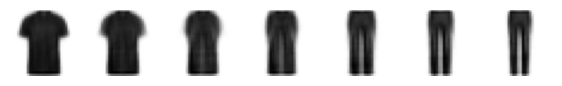

In [59]:
plot_multiple_images(images)

plt.show()

## Discrete VAE

There's a bug in `F.gumbel_softmax()` on MPS devices (see [PyTorch issue #159103](https://github.com/pytorch/pytorch/issues/159103)) so the code below works around it:

In [60]:
def gumbel_softmax(logits, tau=1, hard=False, dim=-1):
    if device != "mps":
        return F.gumbel_softmax(logits, tau, hard, dim)
    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    gumbels = torch.clamp(gumbels, -30, 30)  # <<<<<<<<<<<<<<<<<<<<< ADDED
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [61]:
DiscreteVAEOutput = namedtuple("DiscreteVAEOutput",
                               ["output", "logits", "codings_prob"])

class DiscreteVAE(nn.Module):
    def __init__(self, coding_length=32, n_codes=16, temperature=1.0):
        super().__init__()
        self.coding_length = coding_length
        self.n_codes = n_codes
        self.temperature = temperature
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, coding_length * n_codes),
            nn.Unflatten(dim=1, unflattened_size=(coding_length, n_codes)))
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(coding_length * n_codes, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        logits = self.encoder(X)
        codings_prob = gumbel_softmax(logits, tau=self.temperature, hard=True)
        output = self.decoder(codings_prob)
        return DiscreteVAEOutput(output, logits, codings_prob)

**Note**: when computing the Gumbel-Softmax reparameterization, `hard=True` makes the forward pass use a one-hot sample, but the backward pass uses the soft (differentiable) sample.

In [62]:
def d_vae_loss(y_pred, y_target, kl_weight=1.0):
    output, logits, _ = y_pred
    codings_prob = F.softmax(logits, -1)
    k = logits.new_tensor(logits.size(-1))  # same device and dtype as logits
    kl_div = (codings_prob * (codings_prob.log() + k.log())).sum(dim=(1, 2))
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [63]:
n_epochs = 20
def annealing(model, epoch):
    model.temperature = 1 - 0.9 * epoch / n_epochs

torch.manual_seed(42)
d_vae = DiscreteVAE().to(device)
optimizer = torch.optim.NAdam(d_vae.parameters(), lr=0.001)
history = train(d_vae, optimizer, d_vae_loss, rmse, train_loader, valid_loader,
                n_epochs=n_epochs, epoch_callback=annealing)

Epoch 1/20,                      train loss: 0.0581, train metric: 0.228, valid metric: 0.208
Epoch 2/20,                      train loss: 0.0471, train metric: 0.198, valid metric: 0.192
Epoch 3/20,                      train loss: 0.0435, train metric: 0.188, valid metric: 0.186
Epoch 4/20,                      train loss: 0.0417, train metric: 0.184, valid metric: 0.183
Epoch 5/20,                      train loss: 0.0399, train metric: 0.18, valid metric: 0.179
Epoch 6/20,                      train loss: 0.0391, train metric: 0.178, valid metric: 0.179
Epoch 7/20,                      train loss: 0.0386, train metric: 0.177, valid metric: 0.177
Epoch 8/20,                      train loss: 0.0378, train metric: 0.175, valid metric: 0.175
Epoch 9/20,                      train loss: 0.0374, train metric: 0.174, valid metric: 0.175
Epoch 10/20,                      train loss: 0.0370, train metric: 0.172, valid metric: 0.173
Epoch 11/20,                      train loss: 0.0367, train 

In [64]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
codings = torch.randint(0, d_vae.n_codes,  # from 0 to k – 1
                        (n_images, d_vae.coding_length), device=device)
codings_prob = F.one_hot(codings, num_classes=d_vae.n_codes).float()
with torch.no_grad():
    images = d_vae.decoder(codings_prob)

Now let's plot these images:

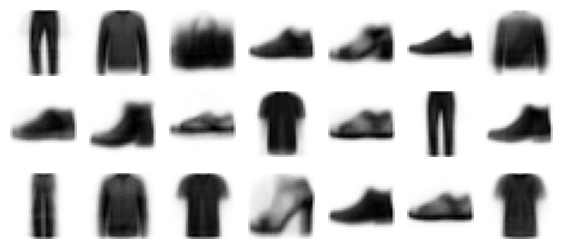

In [65]:
plot_multiple_images(images, 7)
plt.show()

# Generative Adversarial Networks

In [66]:
torch.manual_seed(42)  # extra code – ensures reproducibility

codings_dim = 32
generator = nn.Sequential(
    nn.Linear(codings_dim, 128), nn.ReLU(),
    nn.Linear(128, 256), nn.ReLU(),
    nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))).to(device)
discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1), nn.Sigmoid()).to(device)

In [67]:
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            noise = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(noise).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()
    
            noise = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(noise)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()

Epoch 1/20 | discriminator loss: 1.4485 | generator loss: 0.8686


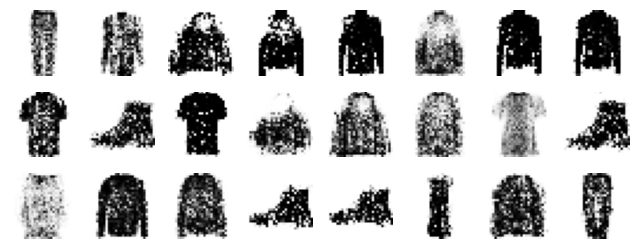

Epoch 2/20 | discriminator loss: 1.2745 | generator loss: 0.8481
Epoch 3/20 | discriminator loss: 1.2396 | generator loss: 0.8620
Epoch 4/20 | discriminator loss: 1.2174 | generator loss: 0.9817
Epoch 5/20 | discriminator loss: 1.1699 | generator loss: 0.8260
Epoch 6/20 | discriminator loss: 1.3670 | generator loss: 0.8150
Epoch 7/20 | discriminator loss: 1.3969 | generator loss: 0.8480
Epoch 8/20 | discriminator loss: 1.0266 | generator loss: 1.9537
Epoch 9/20 | discriminator loss: 1.0527 | generator loss: 0.9703
Epoch 10/20 | discriminator loss: 1.2959 | generator loss: 0.9208
Epoch 11/20 | discriminator loss: 1.2030 | generator loss: 0.9285


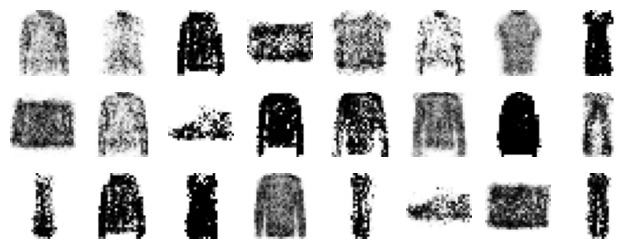

Epoch 12/20 | discriminator loss: 1.1509 | generator loss: 0.8861
Epoch 13/20 | discriminator loss: 1.2532 | generator loss: 0.8730
Epoch 14/20 | discriminator loss: 1.2339 | generator loss: 0.8337
Epoch 15/20 | discriminator loss: 1.2986 | generator loss: 0.7917
Epoch 16/20 | discriminator loss: 1.3456 | generator loss: 0.8056
Epoch 17/20 | discriminator loss: 1.3199 | generator loss: 0.9077
Epoch 18/20 | discriminator loss: 1.1755 | generator loss: 1.1950
Epoch 19/20 | discriminator loss: 1.1846 | generator loss: 0.8003
Epoch 20/20 | discriminator loss: 1.2624 | generator loss: 0.8731


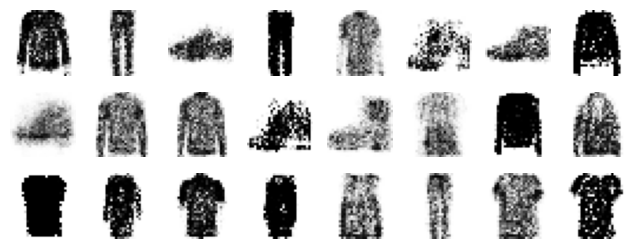

In [68]:
torch.manual_seed(42)
train_gan(generator, discriminator, train_loader, codings_dim)

In [69]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
generator.eval()
codings = torch.randn(n_images, codings_dim, device=device)
with torch.no_grad():
    generated_images = generator(codings)

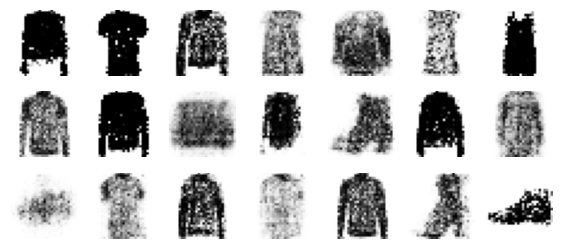

In [70]:
# extra code – this cell generates Figure 17–15
plot_multiple_images(generated_images, 7)

plt.show()

# Deep Convolutional GAN

In [71]:
torch.manual_seed(1)  # extra code – ensures reproducibility

dc_codings_dim = 100

dc_generator = nn.Sequential(
    nn.Linear(dc_codings_dim, 128 * 7 * 7),
    nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1,
                   output_padding=1), nn.Sigmoid()).to(device)
dc_discriminator = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 32 x 14 x 14
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 64 x 7 x 7
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 1), nn.Sigmoid()).to(device)

Epoch 1/20 | discriminator loss: 1.8756 | generator loss: 0.7518


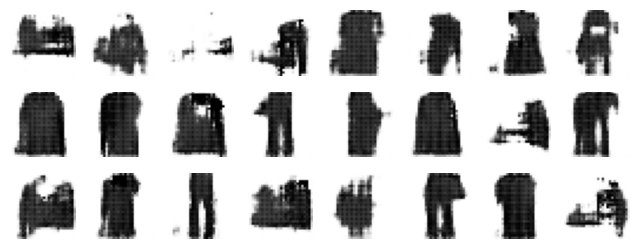

Epoch 2/20 | discriminator loss: 1.1220 | generator loss: 0.9433
Epoch 3/20 | discriminator loss: 1.1363 | generator loss: 0.9931
Epoch 4/20 | discriminator loss: 1.1780 | generator loss: 1.0582
Epoch 5/20 | discriminator loss: 0.8303 | generator loss: 1.2002
Epoch 6/20 | discriminator loss: 0.8487 | generator loss: 1.2385
Epoch 7/20 | discriminator loss: 0.8938 | generator loss: 1.2018
Epoch 8/20 | discriminator loss: 0.9621 | generator loss: 1.1554
Epoch 9/20 | discriminator loss: 0.8433 | generator loss: 1.4558
Epoch 10/20 | discriminator loss: 0.7386 | generator loss: 1.3724
Epoch 11/20 | discriminator loss: 0.6681 | generator loss: 1.8371


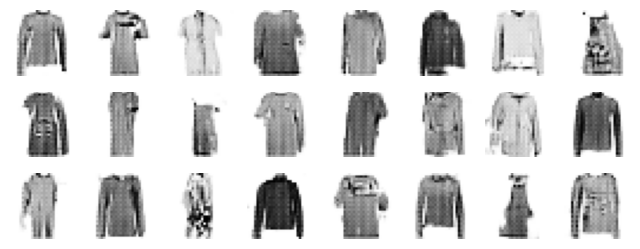

Epoch 12/20 | discriminator loss: 0.8693 | generator loss: 1.4240
Epoch 13/20 | discriminator loss: 0.4677 | generator loss: 1.7121
Epoch 14/20 | discriminator loss: 0.6501 | generator loss: 1.6613
Epoch 15/20 | discriminator loss: 0.7068 | generator loss: 1.7394
Epoch 16/20 | discriminator loss: 0.5615 | generator loss: 1.6353
Epoch 17/20 | discriminator loss: 0.7534 | generator loss: 1.9217
Epoch 18/20 | discriminator loss: 0.8159 | generator loss: 2.1757
Epoch 19/20 | discriminator loss: 0.8734 | generator loss: 1.8969
Epoch 20/20 | discriminator loss: 0.5449 | generator loss: 1.8527


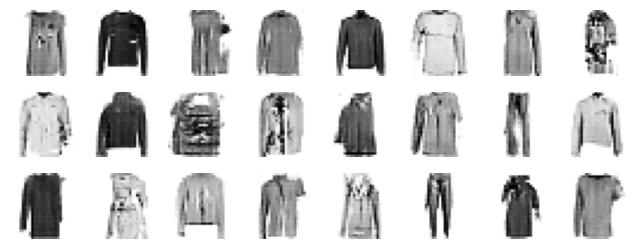

In [72]:
torch.manual_seed(42)
train_gan(dc_generator, dc_discriminator, train_loader, dc_codings_dim)

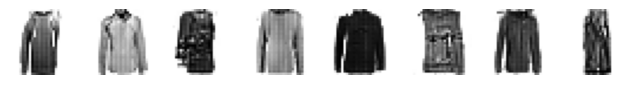

In [73]:
# extra code – this cell generates Figure 17–16
torch.manual_seed(42)
noise = torch.randn(8, dc_codings_dim, device=device)
generated_images = dc_generator(noise)
plot_multiple_images(generated_images, 8)

# Diffusion Models

Starting with an image from the dataset, at each time step $t$, the diffusion process adds Gaussian noise with mean 0 and variance $\beta_t$. The model is then trained to reverse that process. More specifically, given a noisy image produced by the forward process, and given the time $t$, the model is trained to predict the total noise that was added to the original image, scaled to variance 1.

The [DDPM paper](https://arxiv.org/abs/2006.11239) increased $\beta_t$ from $\beta_1$ = 0.0001 to $\beta_T = $0.02 ($T$ is the max step), but the [Improved DDPM paper](https://arxiv.org/pdf/2102.09672.pdf) suggested using the following $\cos^2(\ldots)$ schedule instead, which gradually decreases $\bar{\alpha_t} = \prod_{i=0}^{t} \alpha_i$ from 1 to 0, where $\alpha_t = 1 - \beta_t$:

In [74]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = torch.linspace(0, T, T + 1)
    f = torch.cos((t / T + s) / (1 + s) * torch.pi / 2) ** 2
    alpha_bars = f / f[0]
    betas = (1 - (f[1:] / f[:-1])).clamp(max=max_beta)
    betas = torch.cat([torch.zeros(1), betas])  # for easier indexing
    alphas = 1 - betas
    return alphas, betas, alpha_bars

torch.manual_seed(42)  # extra code – for reproducibility
T = 4000
alphas, betas, alpha_bars = variance_schedule(T)

In the DDPM paper, the authors used $T = 1,000$, while in the Improved DDPM, they bumped this up to $T = 4,000$, so we use this value. The variables `alphas`, `betas`, and `alpha_bars` contain $\alpha_t$, $\beta_t$, $\bar{\alpha}_t$ respectively, starting from _t_ = 0.

Let's plot `alpha_bars`:

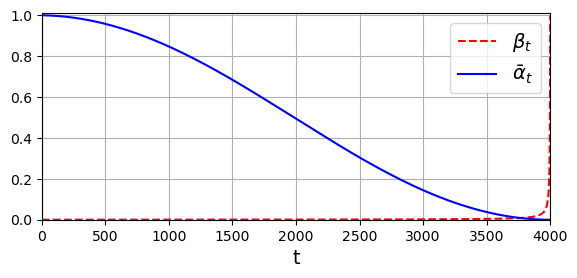

In [75]:
# extra code – this cell generates Figure 17–21
plt.figure(figsize=(6, 3))
plt.plot(betas, "r--", label=r"$\beta_t$")
plt.plot(alpha_bars, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1.01])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()

plt.show()

The following function uses equation (4) from the DDPM paper to compute the noisy images in one shot, directly from the original images. It's a shortcut for the forward diffusion process.

In [76]:
def forward_diffusion(x0, t):
    eps = torch.randn_like(x0)  # this unscaled noise will be the target
    xt = alpha_bars[t].sqrt() * x0 + (1 - alpha_bars[t]).sqrt() * eps
    return xt, eps

Each input is a `DiffusionSample` instance containing the noisy image, and the corresponding time step.

In [77]:
class DiffusionSample(namedtuple("DiffusionSampleBase", ["xt", "t"])):
    def to(self, device):
        return DiffusionSample(self.xt.to(device), self.t.to(device))

The `DiffusionDataset` function takes an image dataset, and for each image, it scales the pixel values between –1 and +1, then picks a random time step between 1 and _T_ and adds the corresponding noise, then it returns a tuple with the input and the target. The input is a `DiffusionSample`, and the target is the unscaled noise `eps`:

In [78]:
class DiffusionDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, i):
        x0, _ = self.dataset[i]
        x0 = (x0 * 2) - 1  # scale from –1 to +1
        t = torch.randint(1, T + 1, size=[1])
        xt, eps = forward_diffusion(x0, t)
        return DiffusionSample(xt, t), eps

    def __len__(self):
        return len(self.dataset)

train_set = DiffusionDataset(train_data)  # wrap Fashion MNIST
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [79]:
valid_set = DiffusionDataset(valid_data)
valid_loader = DataLoader(valid_set, batch_size=32)

As a quick sanity check, let's take a look at a few training samples, along with the corresponding noise to predict, and the original images (which we get by subtracting the appropriately scaled noise from the appropriately scaled noisy image):

Original images


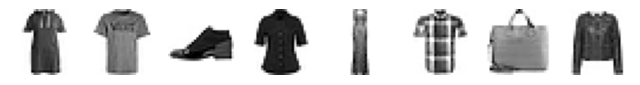

Time steps: [2027, 1463, 3720, 9, 611, 2202, 2118, 388]
Noisy images


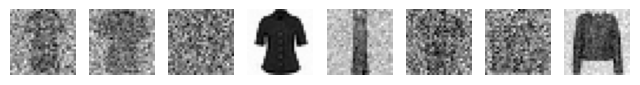

Noise to predict


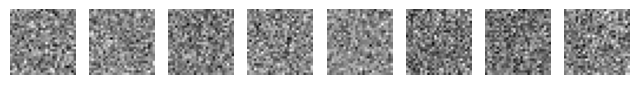

In [80]:
# extra code – just a quick sanity check

def original_image(sample, noise):
    alpha_bars_t = torch.gather(alpha_bars, dim=0, index=sample.t.squeeze(1))
    alpha_bars_t = alpha_bars_t.view(-1, 1, 1, 1)
    x0 = (sample.xt - (1 - alpha_bars_t).sqrt() * noise) / alpha_bars_t.sqrt()
    return torch.clamp((x0 + 1) / 2, 0, 1)

torch.manual_seed(42)
sample, eps = next(iter(train_loader))  # get the first batch
x0 = original_image(sample, eps).to(device)

print("Original images")
plot_multiple_images(x0[:8])
plt.show()
print("Time steps:", sample.t[:8].view(-1).tolist())
print("Noisy images")
plot_multiple_images(sample.xt[:8])
plt.show()
print("Noise to predict")
plot_multiple_images(eps[:8])
plt.show()

Now we're ready to build the diffusion model itself. It will need to process both images and times. We will encode the times using a sinusoidal encoding, as suggested in the DDPM paper, just like in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper. Given a vector of _m_ integers representing time indices (integers), the layer returns an _m_ × _d_ matrix, where _d_ is the chosen embedding size.

In [81]:
# extra code – implements a custom time encoding layer

embed_dim = 64

class TimeEncoding(nn.Module):
    def __init__(self, T, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        p = torch.arange(T + 1).unsqueeze(1)
        angle = p / 10_000 ** (torch.arange(0, embed_dim, 2) / embed_dim)
        te = torch.empty(T + 1, embed_dim)
        te[:, 0::2] = torch.sin(angle)
        te[:, 1::2] = torch.cos(angle)
        self.register_buffer("time_encodings", te)

    def forward(self, t):
        return self.time_encodings[t]

Now let's build the model. In the Improved DDPM paper, they use a UNet model. We'll create a UNet-like model, that processes the image through `Conv2d` + `BatchNorm2d` layers and skip connections, gradually downsampling the image (using `MaxPool2d` layers with `stride=2`), then growing it back again (using `Upsample` layers). Skip connections are also added across the downsampling part and the upsampling part. We also add the time encodings to the output of each block, after passing them through a `Linear` layer to resize them to the right dimension.

* **Note**: an image's time encoding is added to every pixel in the image, along the last axis (channels). So the number of units in the `Conv2d` layer must correspond to the embedding size, and we must reshape the `time_enc` tensor to add the width and height dimensions.
* This UNet implementation was inspired by keras.io's [image segmentation example](https://keras.io/examples/vision/oxford_pets_image_segmentation/), as well as from the [official diffusion models implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py). Compared to the first implementation, I added a few things, especially time encodings and skip connections across down/up parts. Compared to the second implementation, I removed a few things, especially the attention layers. It seemed like overkill for Fashion MNIST, but feel free to add them.

In [82]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class DiffusionModel(nn.Module):
    def __init__(self, T=T, embed_dim=64):
        super().__init__()
        self.time_encoding = TimeEncoding(T, embed_dim)

        # Init
        dim = 16
        self.pad = nn.ConstantPad2d((3, 3, 3, 3), 0)
        self.init_conv = nn.Conv2d(1, dim, kernel_size=3)
        self.init_bn = nn.BatchNorm2d(dim)
        self.time_adapter_init = nn.Linear(embed_dim, dim)

        # Down path
        self.down_blocks = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.time_adapters_down = nn.ModuleList()
        in_dim = dim
        for dim in (32, 64, 128):
            block = nn.Sequential(
                nn.ReLU(),
                SeparableConv2d(in_dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                SeparableConv2d(dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1, stride=2)
            self.down_blocks.append(block)
            self.skip_convs.append(skip_conv)
            self.time_adapters_down.append(nn.Linear(embed_dim, dim))
            in_dim = dim

        # Up path
        self.up_blocks = nn.ModuleList()
        self.skip_up_convs = nn.ModuleList()
        self.time_adapters_up = nn.ModuleList()
        for dim in (64, 32, 16):
            block = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                nn.ConvTranspose2d(dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1)
            self.up_blocks.append(block)
            self.skip_up_convs.append(skip_conv)
            self.time_adapters_up.append(nn.Linear(embed_dim, dim))
            in_dim = dim * 3  # because of concatenation with cross skip

        self.final_conv = nn.Conv2d(in_dim, 1, 3, padding=1)

    def forward(self, sample):
        if not isinstance(sample, DiffusionSample):
            print(repr(sample))
        time_enc = self.time_encoding(sample.t.squeeze(1))  # [batch, embed_dim]
        z = self.pad(sample.xt)
        z = F.relu(self.init_bn(self.init_conv(z)))
        z = z + self.time_adapter_init(time_enc)[:, :, None, None]
        skip = z
        cross_skips = []

        # Downsampling path
        for block, skip_conv, time_adapter in zip(
                self.down_blocks, self.skip_convs, self.time_adapters_down):
            z = block(z)
            cross_skips.append(z)
            z = F.max_pool2d(z, 3, stride=2, padding=1)
            skip_link = skip_conv(skip)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            skip = z

        # Upsampling path
        for block, skip_up_conv, time_adapter in zip(
                self.up_blocks, self.skip_up_convs, self.time_adapters_up):
            z = block(z)
            z = F.interpolate(z, scale_factor=2, mode="nearest")
            skip_link = F.interpolate(skip, scale_factor=2, mode="nearest")
            skip_link = skip_up_conv(skip_link)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            cross_skip = cross_skips.pop()
            z = torch.cat([z, cross_skip], dim=1)
            skip = z

        out = self.final_conv(z)
        out = out[:, :, 2:-2, 2:-2]  # cropping
        return out.contiguous()

Now let's train the model!

In [83]:
torch.manual_seed(42)
diffusion_model = DiffusionModel().to(device)
huber = nn.HuberLoss()
optimizer = torch.optim.NAdam(diffusion_model.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(diffusion_model, optimizer, huber, rmse, train_loader, valid_loader,
                n_epochs=20)

Epoch 1/20,                      train loss: 0.0658, train metric: 0.376, valid metric: 0.331
Epoch 2/20,                      train loss: 0.0653, train metric: 0.463, valid metric: 0.316
Epoch 3/20,                      train loss: 0.0452, train metric: 0.31, valid metric: 0.306
Epoch 4/20,                      train loss: 0.2452, train metric: 3.75, valid metric: 0.302
Epoch 5/20,                      train loss: 0.0421, train metric: 0.299, valid metric: 0.295
Epoch 6/20,                      train loss: 0.0414, train metric: 0.297, valid metric: 0.297
Epoch 7/20,                      train loss: 0.0412, train metric: 0.296, valid metric: 0.293
Epoch 8/20,                      train loss: 0.0405, train metric: 0.294, valid metric: 0.295
Epoch 9/20,                      train loss: 0.0402, train metric: 0.293, valid metric: 0.293
Epoch 10/20,                      train loss: 0.0402, train metric: 0.293, valid metric: 0.289
Epoch 11/20,                      train loss: 0.0395, train m

Now that the model is trained, we can use it to generate new images. For this, we just generate Gaussian noise, and pretend this is the result of the diffusion process, and we're at time $T$. Then we use the model to predict the image at time $T - 1$, then we call it again to get $T - 2$, and so on, removing a bit of noise at each step. At the end, we get an image that looks like it's from the Fashion MNIST dataset. The equation for this reverse process is at the top of page 4 in the DDPM paper (step 4 in algorithm 2).

In [84]:
def generate_ddpm(model, batch_size=32):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        for t in range(T, 0, -1):
            print(f"\rt = {t}", end=" ")  # extra code — show progress
            alpha_t = alphas[t]
            beta_t = betas[t]
            alpha_bar_t = alpha_bars[t]
            noise = (torch.randn(xt.shape, device=device)
                     if t > 1 else torch.zeros(xt.shape, device=device))
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            xt = (1 / alpha_t.sqrt()
                  * (xt - beta_t / (1 - alpha_bar_t).sqrt() * eps_pred)
                  + (1 - alpha_t).sqrt() * noise)
        return torch.clamp((xt + 1) / 2, 0, 1)

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen = generate_ddpm(diffusion_model)  # generated images

t = 1    

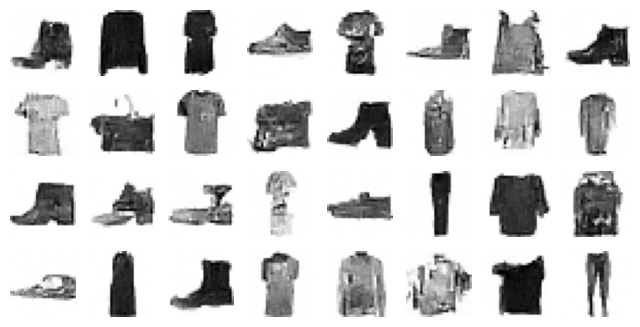

In [85]:
plot_multiple_images(X_gen, 8)
plt.show()

Some of these images are really convincing! Compared to GANs, diffusion models tend to generate more diverse images, and they have surpassed GANs in image quality. Moreover, training is much more stable. However, generating images takes *much* longer.

In [86]:
def generate_ddim(model, batch_size=32, num_steps=50, eta=0.85):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        times = torch.linspace(T - 1, 0, steps=num_steps + 1).long().tolist()
        for t, t_prev in zip(times[:-1], times[1:]):
            print(f"\rt = {t}", end=" ")
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            x0 = ((xt - (1 - alpha_bars[t]).sqrt() * eps_pred)
                  / (alpha_bars[t].sqrt()))
            abar_t_prev = alpha_bars[t_prev]
            variance = eta * (1 - abar_t_prev) / (1 - alpha_bars[t]) * betas[t]
            sigma_t = variance.sqrt()
            pred_dir = (1 - abar_t_prev - sigma_t**2).sqrt() * eps_pred
            noise = torch.randn_like(xt)
            xt = abar_t_prev.sqrt() * x0 + pred_dir + sigma_t * noise

        return torch.clamp((xt + 1) / 2, 0, 1)  # from [–1, 1] range to [0, 1]

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen_ddim = generate_ddim(diffusion_model, num_steps=500)

t = 7    

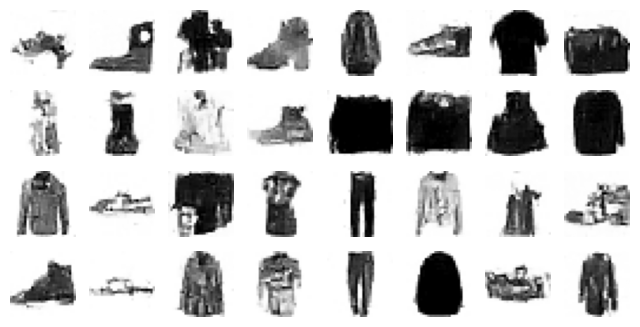

In [87]:
plot_multiple_images(X_gen_ddim, 8)
plt.show()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/1 [00:00<?, ?it/s]

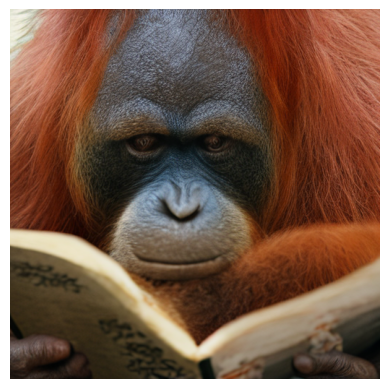

In [88]:
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sd-turbo", variant="fp16", dtype=torch.float16)
pipe.to(device)
prompt = "A closeup photo of an orangutan reading a book"
torch.manual_seed(26)
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image.save("my_orangutan_reading.png")
plt.imshow(image)
plt.axis("off")
plt.show()

# Exercise Solutions

TODO